In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

### 数据集
我们将使用一个小型 数据集，该数据集由克利夫兰心脏病诊所基金会（Cleveland Clinic Foundation for Heart Disease）提供。CSV 中有几百行数据。每行描述了一个病人（patient），每列描述了一个属性（attribute）。我们将使用这些信息来预测一位病人是否患有心脏病，这是在该数据集上的二分类任务。

下面是该数据集的描述。 请注意，有数值（numeric）和类别（categorical）类型的列。

| 列 | 描述 | 特征类型 | 数据类型 |
| :--- | :--- | :--- | :--- |
| Age | 年龄以年为单位 | Numerical | integer |
| Sex | （1 = 男；0 = 女） | Categorical | integer |
| CP | 胸痛类型（0，1，2，3，4） | Categorical | integer |
| Trestbpd | 静息血压（入院时，以mm Hg计） | Numerical | integer |
| Chol | 血清胆固醇（mg/dl） | Numerical | integer |
| FBS | （空腹血糖> 120 mg/dl）（1 = true；0 = false） | Categorical | integer |
| RestECG | 静息心电图结果（0，1，2） | Categorical | integer |
| Thalach | 达到的最大心率 | Numerical | integer |
| Exang | 运动诱发心绞痛（1 =是；0 =否） | Categorical | integer |
| Oldpeak | 与休息时相比由运动引起的 ST 节段下降 | Numerical | integer |
| Slope | 在运动高峰 ST 段的斜率 | Numerical | float |
| CA | 荧光透视法染色的大血管动脉（0-3）的数量 | Numerical | integer |
| Thal | 3 =正常；6 =固定缺陷；7 =可逆缺陷 | Categorical | string |
| Target | 心脏病诊断（1 = true；0 = false） | Classification | integer |

In [4]:
csv_file = 'data/heart.csv'
dataframe = pd.read_csv(csv_file)
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [5]:
# 将数据集拆分成训练、验证、测试集
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


In [14]:
test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
197,57,1,4,110,201,0,0,126,1,1.5,2,0,fixed,0
209,60,0,1,150,240,0,0,171,0,0.9,1,0,normal,0
226,57,1,4,110,335,0,0,143,1,3.0,2,1,reversible,1
158,38,1,1,120,231,0,0,182,1,3.8,2,0,reversible,1
108,68,1,3,118,277,0,0,151,0,1.0,1,1,reversible,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,57,1,2,124,261,0,0,141,0,0.3,1,0,reversible,0
67,41,1,2,135,203,0,0,132,0,0.0,2,0,fixed,0
182,54,1,4,122,286,0,2,116,1,3.2,2,2,normal,1
34,44,1,3,130,233,0,0,179,1,0.4,1,0,normal,0


In [16]:
# 一种从 Pandas Dataframe 创建 tf.data 数据集的实用程序方法（utility method）
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [17]:
batch_size = 5 # 小批量大小用于演示
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [19]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['age'])
  print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([70 53 50 69 40], shape=(5,), dtype=int32)
A batch of targets: tf.Tensor([1 0 1 0 1], shape=(5,), dtype=int32)


###### demo

In [20]:
# 我们将使用该批数据演示几种特征列
example_batch = next(iter(train_ds))[0]

# 用于创建一个特征列
# 并转换一批次数据的一个实用程序方法
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [21]:
# 数值列
age = feature_column.numeric_column("age")
demo(age)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[60.]
 [58.]
 [41.]
 [53.]
 [44.]]


In [22]:
# 分桶列
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [23]:
# 分类列
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])

thal_one_hot = feature_column.indicator_column(thal)
demo(thal_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [24]:
# 嵌入列
# 注意到嵌入列的输入是我们之前创建的类别列
thal_embedding = feature_column.embedding_column(thal, dimension=8)
demo(thal_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 0.05809537  0.16515978  0.54063356  0.01538548 -0.3389014  -0.3258344
   0.39929628  0.36251605]
 [ 0.61365944  0.23139054  0.08804638  0.17136863 -0.11177348 -0.19876836
   0.38424614 -0.19792196]
 [ 0.61365944  0.23139054  0.08804638  0.17136863 -0.11177348 -0.19876836
   0.38424614 -0.19792196]
 [ 0.05809537  0.16515978  0.54063356  0.01538548 -0.3389014  -0.3258344
   0.39929628  0.36251605]
 [ 0.41959736 -0.03895184  0.67341954 -0.45324713 -0.19429901 -0.32469323
  -0.19206688  0.37369296]]


In [37]:
# 哈希处理特征列
thal_hashed = feature_column.categorical_column_with_hash_bucket(
      'thal', hash_bucket_size=1000)
demo(feature_column.indicator_column(thal_hashed))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [40]:
# 组合特征列
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
demo(feature_column.indicator_column(crossed_feature))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


###### 选择要使用的列

In [42]:
feature_columns = []

# 数值列
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
  feature_columns.append(feature_column.numeric_column(header))

# 分桶列
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 分类列
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# 嵌入列
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# 组合列
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

In [43]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='thal', vocabulary_list=('fixed', 'normal', 'reversi

In [44]:
# 定义密集特征（DenseFeatures）
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [46]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/30
7/7 [==============================] - 0s 34ms/step - loss: 1.2993 - accuracy: 0.6321 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
7/7 [==============================] - 0s 29ms/step - loss: 1.1212 - accuracy: 0.4974 - val_loss: 1.4321 - val_accuracy: 0.6939
Epoch 3/30
7/7 [==============================] - 0s 29ms/step - loss: 0.9934 - accuracy: 0.7098 - val_loss: 1.9788 - val_accuracy: 0.3061
Epoch 4/30
7/7 [==============================] - 0s 31ms/step - loss: 1.3712 - acc

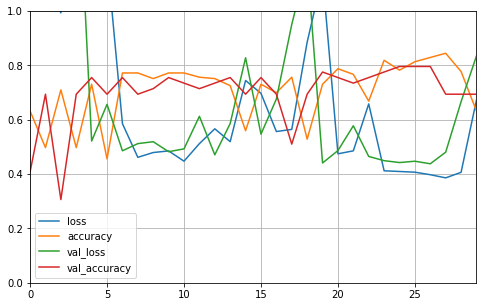

In [52]:
from custom_api.img_show import plot_learning_curves
%matplotlib inline
plot_learning_curves(history, 1)

In [53]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 21ms/step - loss: 0.7637 - accuracy: 0.7377
Accuracy 0.73770493


In [61]:
import os
output_dir = 'baseline_model'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
baseline_estimator = tf.estimator.BaselineClassifier(model_dir = output_dir, n_classes = 2)
baseline_estimator.train(input_fn = lambda : df_to_dataset(train, batch_size=batch_size))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'baseline_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021DC5997FC8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done

FailedPreconditionError: GetNext() failed because the iterator has not been initialized. Ensure that you have run the initializer operation for this iterator before getting the next element.
	 [[node IteratorGetNext (defined at e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]

Original stack trace for 'IteratorGetNext':
  File "e:\program files\python\python37-64\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "e:\program files\python\python37-64\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "e:\program files\python\python37-64\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "e:\program files\python\python37-64\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "e:\program files\python\python37-64\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "e:\program files\python\python37-64\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "e:\program files\python\python37-64\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "e:\program files\python\python37-64\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "e:\program files\python\python37-64\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "e:\program files\python\python37-64\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "e:\program files\python\python37-64\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "e:\program files\python\python37-64\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "e:\program files\python\python37-64\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "e:\program files\python\python37-64\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "e:\program files\python\python37-64\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "e:\program files\python\python37-64\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "e:\program files\python\python37-64\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "e:\program files\python\python37-64\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "e:\program files\python\python37-64\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "e:\program files\python\python37-64\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "e:\program files\python\python37-64\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "e:\program files\python\python37-64\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "e:\program files\python\python37-64\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "e:\program files\python\python37-64\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "e:\program files\python\python37-64\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "e:\program files\python\python37-64\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "e:\program files\python\python37-64\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-7650a331e642>", line 6, in <module>
    baseline_estimator.train(input_fn = lambda : df_to_dataset(train, batch_size=batch_size))
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 370, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1160, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1187, in _train_model_default
    input_fn, ModeKeys.TRAIN))
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1024, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_estimator\python\estimator\util.py", line 65, in parse_input_fn_result
    result = iterator.get_next()
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\data\ops\iterator_ops.py", line 426, in get_next
    name=name)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\ops\gen_dataset_ops.py", line 2499, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3360, in create_op
    attrs, op_def, compute_device)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3429, in _create_op_internal
    op_def=op_def)
  File "e:\program files\python\python37-64\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1751, in __init__
    self._traceback = tf_stack.extract_stack()
